# DeepSeedlings: Vectorize Images
Using pre-trained Tensorflow CNNs (with the last layer 'cut' off) to vectorize images.

In [1]:
%matplotlib inline
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16
import numpy as np
import os
import cv2
import pandas as pd
import seaborn as sns
import keras
from keras import backend as K
from keras.applications import xception
from keras.preprocessing import image
from keras import optimizers

from keras.models import Model
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from tqdm import tqdm
import pickle


num_samples_of_train_data_per_species = 200
num_samples_of_test_data = 200

# overview of directories
print('current directory:')
!ls  
print('\nparent directory:')
!ls ..  

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


current directory:
anaconda3
DeepSeedlings-Part1.ipynb
DeepSeedlings-Part1-VectorizeImages-PretrainedNNs-Copy1.ipynb
DeepSeedlings-Part1-VectorizeImages-PretrainedNNs.ipynb
DeepSeedlings-Part1-VectorizeImages-PretrainedNNs-SoftmaxClassifier-Copy1.ipynb
DeepSeedlings-Part1-VectorizeImages-PretrainedNNs-SoftmaxClassifier.ipynb
DeepSeedlings-Part2-simpleclassifier.ipynb
DeepSeedlings-Part3-FullCNN.ipynb
dev
input
kagglexception.ipynb
logs
notebook.ipynb
Nvidia_Cloud_EULA.pdf
seedlingscript.py
seedlings.tar.gz
src
test.zip
test.zip.1
tmp
trainseedlingcnn.py
train_x_bf.p
train_x_inception.p
train_x_vgg19.p
train_x_xception.p
tutorials
Untitled.ipynb
valid_x_bf.p
valid_x_inception.p
valid_x_vgg19.p
valid_x_xception.p
x_aug.npy
xception_seedlings.h5
x_test_bf.npy
x_test_imgs.npy
x_train_valid_bf.npy
x_train_valid_imgs.npy
y_aug.npy
y_train_valid.npy
ytr.p
yv.p

parent directory:
ubuntu


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Exploratory Data Analysis

In [2]:
# input directory
print('input directory:')
!ls ./.kaggle/competitions/plant-seedlings-classification
print('\nfolders containing images of the corresponding species:')
!ls ./.kaggle/competitions/plant-seedlings-classification/train

input directory:
sample_submission.csv	   test      train
sample_submission.csv.zip  test.zip  train.zip

folders containing images of the corresponding species:
Black-grass  Common Chickweed  Loose Silky-bent   Shepherds Purse
Charlock     Common wheat      Maize		  Small-flowered Cranesbill
Cleavers     Fat Hen	       Scentless Mayweed  Sugar beet


In [3]:
CATEGORIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
              'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
NUM_CATEGORIES = len(CATEGORIES)

In [4]:
SAMPLE_PER_CATEGORY = 200
SEED = 1987
data_dir = '/home/ubuntu/.kaggle/competitions/plant-seedlings-classification'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

In [5]:
for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))

Black-grass 263 images
Charlock 390 images
Cleavers 287 images
Common Chickweed 611 images
Common wheat 221 images
Fat Hen 475 images
Loose Silky-bent 654 images
Maize 221 images
Scentless Mayweed 516 images
Shepherds Purse 231 images
Small-flowered Cranesbill 496 images
Sugar beet 385 images


There are at least 221 images for each species of seedling in the dataset.

In [6]:
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
print('train df shape = ', train.shape)
train.head(2)

train df shape =  (4750, 3)


,file,category_id,category
0,train/Black-grass/765a69082.png,0,Black-grass
1,train/Black-grass/b790f7be5.png,0,Black-grass


In [7]:
train = pd.concat([train[train['category'] == c][:SAMPLE_PER_CATEGORY] for c in CATEGORIES])
train = train.sample(frac=1)
train.index = np.arange(len(train))
print('sampled train df shape', train.shape)
train.head(2)

sampled train df shape (2400, 3)


,file,category_id,category
0,train/Shepherds Purse/7a9a62dac.png,9,Shepherds Purse
1,train/Shepherds Purse/bea1ec909.png,9,Shepherds Purse


In [8]:
test = []
for file in os.listdir(test_dir):
    test.append(['test/{}'.format(file), file])
test = pd.DataFrame(test, columns=['filepath', 'file'])
print('test df shape = ', test.shape)
test.head(2)

test df shape =  (794, 2)


,filepath,file
0,test/5bdcfa329.png,5bdcfa329.png
1,test/3d67c434b.png,3d67c434b.png


In [9]:
def read_img(filepath, size = None):
    img = image.load_img(os.path.join(data_dir, filepath))
    img = image.img_to_array(img)
    return img

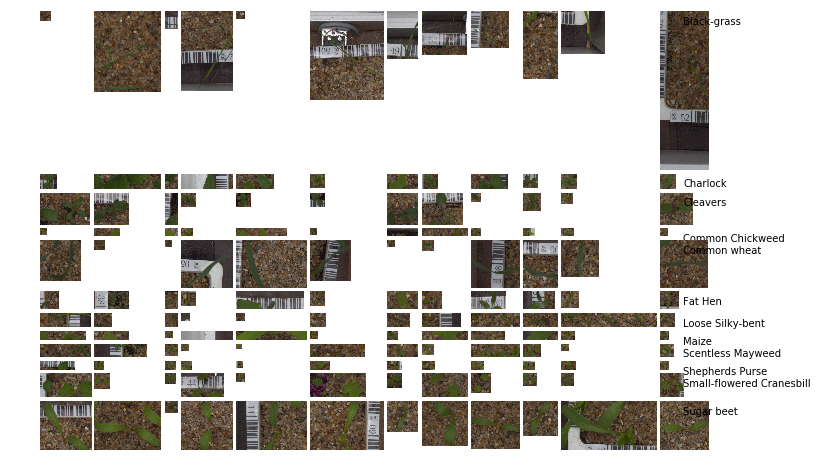

In [10]:
fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)
i = 0
for category_id, category in enumerate(CATEGORIES):
    for filepath in train[train['category'] == category]['file'].values[:NUM_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (224, 224))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i += 1
plt.show();

In [11]:
#np.random.seed(seed=SEED)
#rnd = np.random.random(len(train))
#train_idx = rnd < 0.8
#valid_idx = rnd >= 0.8
#ytr = train.loc[train_idx, 'category_id'].values
#yv = train.loc[valid_idx, 'category_id'].values
#len(ytr), len(yv)

In [12]:
#pickle.dump(ytr, open('ytr.p','wb'))
#pickle.dump(yv, open('yv.p','wb'))

In [13]:
train['image_height'] = 0
train['image_width'] = 0
train['image_channel'] = 0

print('Train set: get shapes of images')
for i in tqdm(range(len(train))):
    img = read_img(train.file.values[i])
    train.loc[i, 'image_height'] = img.shape[0]
    train.loc[i, 'image_width'] = img.shape[1]
    train.loc[i, 'image_channel'] = img.shape[2]

test['image_height'] = 0
test['image_width'] = 0
test['image_channel'] = 0

print('Test set: get shapes of images')
for i in tqdm(range(len(test))):
    img = read_img(test.filepath.values[i])
    test.loc[i, 'image_height'] = img.shape[0]
    test.loc[i, 'image_width'] = img.shape[1]
    test.loc[i, 'image_channel'] = img.shape[2]

  0%|          | 9/2400 [00:00<00:27, 86.25it/s]

Train set: get shapes of images


  2%|▏         | 19/794 [00:00<00:04, 187.91it/s]

Test set: get shapes of images


100%|██████████| 794/794 [00:04<00:00, 177.70it/s]


In [14]:
train.head()

,file,category_id,category,image_height,image_width,image_channel
0,train/Shepherds Purse/7a9a62dac.png,9,Shepherds Purse,370,370,3
1,train/Shepherds Purse/bea1ec909.png,9,Shepherds Purse,105,105,3
2,train/Small-flowered Cranesbill/a2ce7fbfe.png,10,Small-flowered Cranesbill,647,647,3
3,train/Charlock/42203bff1.png,1,Charlock,181,181,3
4,train/Scentless Mayweed/278256e68.png,8,Scentless Mayweed,544,544,3


In [15]:
train.describe()

,category_id,image_height,image_width,image_channel
count,2400.000000,2400.000000,2400.000000,2400.0
mean,5.500000,383.032083,383.785417,3.0
std,3.452772,319.563096,323.770231,0.0
min,0.000000,51.000000,51.000000,3.0
25%,2.750000,145.000000,145.000000,3.0
50%,5.500000,298.000000,298.000000,3.0
75%,8.250000,524.000000,524.000000,3.0
max,11.000000,3457.000000,3652.000000,3.0


In [16]:
test.head()

,filepath,file,image_height,image_width,image_channel
0,test/5bdcfa329.png,5bdcfa329.png,210,210,3
1,test/3d67c434b.png,3d67c434b.png,347,347,3
2,test/4392d93cf.png,4392d93cf.png,212,212,3
3,test/2df78338c.png,2df78338c.png,310,310,3
4,test/615d2b0a9.png,615d2b0a9.png,236,236,3


In [17]:
test.describe()

,image_height,image_width,image_channel
count,794.000000,794.000000,794.0
mean,269.492443,269.492443,3.0
std,43.109211,43.109211,0.0
min,200.000000,200.000000,3.0
25%,232.000000,232.000000,3.0
50%,267.000000,267.000000,3.0
75%,307.000000,307.000000,3.0
max,349.000000,349.000000,3.0


Image sizes vary. We'll need to resize them to (299, 299, 3) so that Xception will take them as input

# Feature Engineering

- Create masks for each seedling
- Segment each seedling
- Resize images to (299, 299, -3)
- Normalize images to range [-1,1]
- Train/Validation/Test split

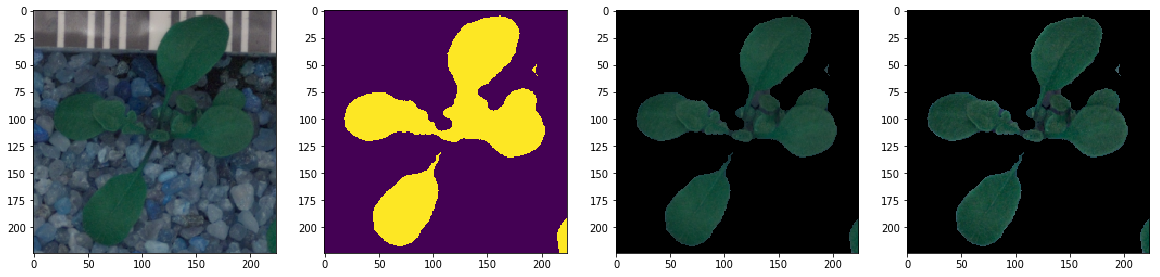

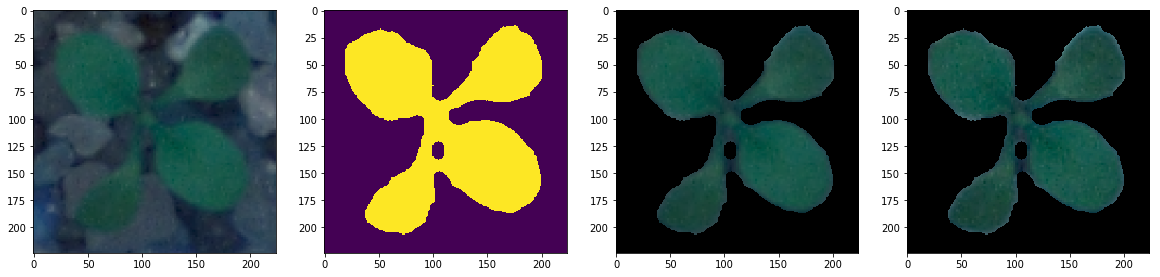

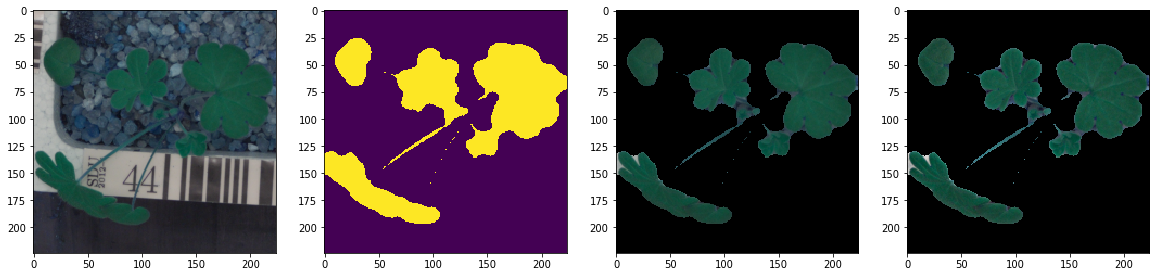

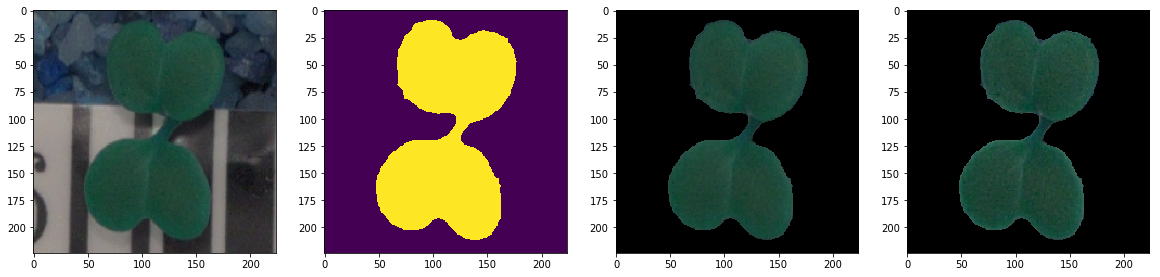

In [18]:
## detect and segment plants in the image 

def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

def read_segmented_image(filepath, img_size):
    img = cv2.imread(os.path.join(data_dir, filepath), cv2.IMREAD_COLOR)
    img = cv2.resize(img.copy(), img_size, interpolation = cv2.INTER_AREA)

    image_mask = create_mask_for_plant(img)
    image_segmented = segment_plant(img)
    image_sharpen = sharpen_image(image_segmented)
    return img, image_mask, image_segmented, image_sharpen
     

# show some images

for i in range(4):
 
    img, image_mask, image_segmented, image_sharpen = read_segmented_image(
        train.loc[i,'file'],(224,224))
        
    fig, axs = plt.subplots(1, 4, figsize=(20, 20))
    axs[0].imshow(img.astype(np.uint8))
    axs[1].imshow(image_mask.astype(np.uint8))
    axs[2].imshow(image_segmented.astype(np.uint8))
    axs[3].imshow(image_sharpen.astype(np.uint8))
        

In [19]:
## read and preprocess all training/validation/test images and labels

def preprocess_image(img):
    img /= 255.
    img -= 0.5
    img *= 2
    return img

target_image_size = 299

print('read and preprocess training and validation images')

# read, preprocess training and validation images  
x_train_valid = np.zeros((len(train), target_image_size, target_image_size, 3),
                         dtype='float32')
y_train_valid = train.loc[:, 'category_id'].values 
for i, filepath in tqdm(enumerate(train['file'])):
    
    # read original images
    #img = read_image(filepath, (target_image_size, target_image_size))
    
    # read segmented image
    _,_,_,img = read_segmented_image(filepath, (target_image_size, target_image_size))
    
    # all pixel values are now between -1 and 1
    x_train_valid[i] = preprocess_image(np.expand_dims(img.copy().astype(np.float), axis=0)) 

print('read and preprocess test images')

# read, preprocess test images  
x_test = np.zeros((len(test), target_image_size, target_image_size, 3), dtype='float32')
for i, filepath in tqdm(enumerate(test['filepath'])):
    
    # read original image
    #img = read_image(filepath, (target_image_size, target_image_size))
    
    # read segmented image
    _,_,_,img = read_segmented_image(filepath, (target_image_size, target_image_size))
    
    # all pixel values are now between -1 and 1
    x_test[i] = preprocess_image(np.expand_dims(img.copy().astype(np.float), axis=0)) 
    
print('x_train_valid.shape = ', x_train_valid.shape)
print('x_test.shape = ', x_test.shape)


8it [00:00, 72.93it/s]

read and preprocess training and validation images


770it [00:13, 55.23it/s]

KeyboardInterrupt: 

In [ ]:
np.save(os.path.join(os.getcwd(),'x_train_valid_imgs.npy'), x_train_valid)
np.save(os.path.join(os.getcwd(),'y_train_valid.npy'), y_train_valid)
np.save(os.path.join(os.getcwd(),'x_test_imgs.npy'), x_test)

## Extract Xception Vectors

In [ ]:
# get vectors for train and validation images
print('x_train_valid.shape = ', x_train_valid.shape)
print('y_train_valid.shape = ', y_train_valid.shape)
print('')

print('Train/Valid set: computing bottleneck features from Xception network')
    
# load xception base model and predict the last layer, resulting in 2048 neurons per image
base_model = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
base_model.compile('sgd','mse')
x_train_valid_bf = base_model.predict(x_train_valid, batch_size=12, verbose=1)

print('')
print('x_train_valid_bf.shape = ', x_train_valid_bf.shape)

print('')
print('save bottleneck features and labels for later ')
np.save(os.path.join(os.getcwd(),'x_train_valid_bf.npy'), x_train_valid_bf)
np.save(os.path.join(os.getcwd(),'y_train_valid.npy'), y_train_valid)

In [ ]:
# get vectors for test images
print('x_test_valid.shape = ', x_train_valid.shape)
print('y_test_valid.shape = ', y_train_valid.shape)
print('')


print('Test set: computing bottleneck features from Xception network')


# load xception base model and predict the last layer comprising 2048 neurons per image
base_model = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
base_model.compile('sgd','mse')
x_test_bf = base_model.predict(x_test, batch_size=32, verbose=1)
     
print('')
print('x_test_bf.shape = ',x_test_bf.shape)

print('save bottleneck features ')
np.save(os.path.join(os.getcwd(),'x_test_bf.npy'), x_test_bf)